# Week 4 Disaster Tweets Project

Hello and welcome to my week 4 kaggle mini project for the deep learning course. Thank you for joining today! This notebook will be broken down into segments of code, along with segments of analysis and dicussion. In this project, we receive three datasets from kaggle. A training dataset which contains the text from tweets along with a target category that identifies whether the tweet is about a disaster or not. The second dataset includes the test set of remaining values, where we use the text from the test tweets so we can predict and submit in the kaggle competition. The final dataset includes a sample submission file that assists us with how our submission is formatted. First off, this notebook will contain our python setup and data loading/cleanup. From there we begin performing EDA on our datasets for a preliminary understanding of how the data is organized and how we can develop a plan for modeling. This data requires a large amount of prepocessing due to the nature of the data: text. We will explore TF-IDF matrices, tokenization, stop words, and embedding. Once our data is cleaned and setup, we will experiment with architectures and begin training models. The best models will be presented. Finally, we will run our best models with the test data and submit to kaggle. Throughout this project, you will find chunks of code and chunks of text to help walkthrough the entire project.

This project is of great importance for several reasons. First we can develop NLP skills along with the RNN/LTSM skills we developed this week in class. Secondly, a strong classifier would be great in the competition but also help to differentiate tweets and potentially other documents between the disaster genre and not. This can quickly help categorize tweets and allow users to locate the tweets needed in case of a nearby disaster. Using advanced versions of this, twitter could help recommend the correct tweets to people in an impacted area. Thank you for joining me today as we explore this disaster tweets problem!

For the next code chunks, we will load in the necessary packages, setup our kaggle environment and port over the data. Join below for a discussion of the data.

In [ ]:
!pip install kaggle

In [ ]:
import os
os.listdir('/content')

['.config', 'kaggle.json', 'sample_data']

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 86.9MB/s]


In [ ]:
import zipfile

zip_file_path = '/content/nlp-getting-started.zip'

extracted_dir_path = '/content/dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection  import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
train = pd.read_csv('/content/dataset/train.csv')
test = pd.read_csv('/content/dataset/test.csv')
sample_submission = pd.read_csv('/content/dataset/sample_submission.csv')

Now that all our imports are complete, we can load in our data and explore it. Our training set has 7,613 total entries including an ID, keyword, location, text, and target. The keyword and location fields include some missing values, however, our analysis only requires the text and target fields, which are complete for all entries. We can see a preview of the data below, where we see some examples of tweets, and as humans, quickly identify whether the tweet is a disaster or not. Due to the large number of tweets both in this dataset and in the real world, it is not physically possible to look at every tweet. Designing a classification model allows us to quickly classify large numbers of tweets.

Moving on to the testing dataset we can see we have 3,262 entries which also include id, keyword, location, text but not target. Our future model will help us predict the target. For our text column, we have no null values and do not need to worry about cleaning there.

Finally, our sample submission includes the layout for our test set submission, where we will identify id and the target. This file will help once we are ready to submit to kaggle.

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [ ]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [ ]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


Here, we can begin some more in depth analysis with the data. In our training set we have 4,342 non-disaster tweets compared to 3,271 disaster tweets. Compared to many targets in other fields, this data is fairly balanced, and does not need extra management in that regard. Accompanying below is a plot of the label distribution as well. Analyzing the word count shows us that the longest tweet in our training set is 31 words long, which is quite short for a collection of 7000+ tweets. The average tweet length is close to 15 with the shortest tweet being 1. A histogram analysis depicts a close to normal distribution of tweet lengths.

In [ ]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

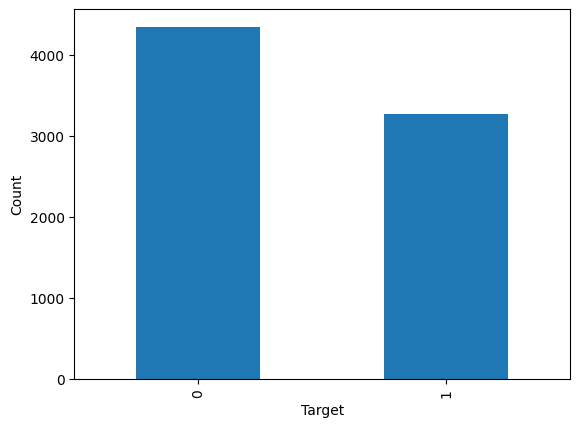

In [ ]:
train['target'].value_counts().plot(kind='bar')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [ ]:
def count_words(text):
    words = text.split()
    return len(words)

train['Word_Count'] = train['text'].apply(count_words)
print(np.mean(train['Word_Count']))
print(np.min(train['Word_Count']))
print(np.max(train['Word_Count']))

14.903585971364771
1
31


Text(0.5, 1.0, 'Word Count')

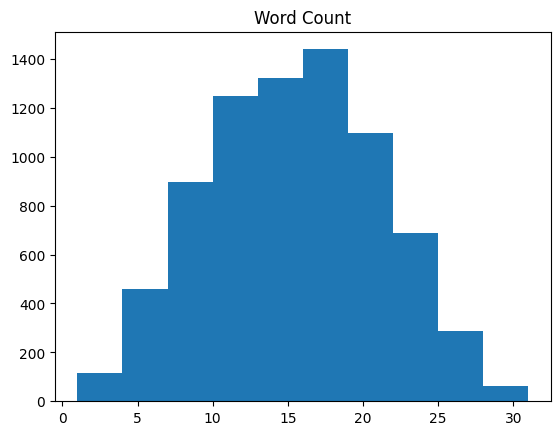

In [ ]:
plt.hist(train['Word_Count'])
plt.title("Word Count")

In the following plot, we can see that the average word lengths between disaster and non-disaster tweets are near identical, with disaster tweets having ever so slightly higher word counts. Both hover around 15 words per tweet. Our next steps will begin our dive into NLP analysis, using TF-IDF and tokenization to prepare our word data.

target
0    14.704744
1    15.167533
Name: Word_Count, dtype: float64


Text(0.5, 1.0, 'Word Count by Target')

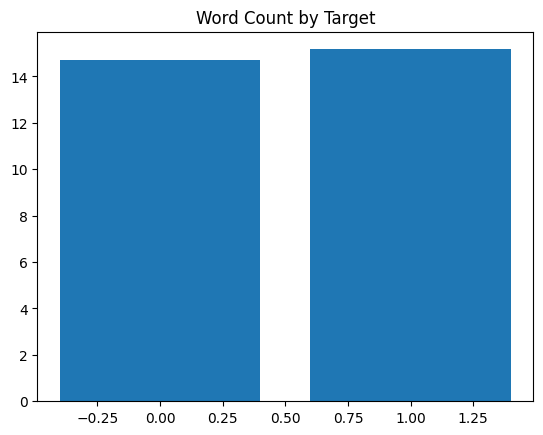

In [ ]:
avgwordcount = train.groupby('target')['Word_Count'].mean()
print(avgwordcount)
plt.bar(avgwordcount.index, avgwordcount)
plt.title("Word Count by Target")

Now we can begin our first steps with Natural Language Processing. First we will apply the TF-IDF method which stands for term frequency, inverse document frequency. This method allows us to fit the vectorizer on our data, and identifies terms that are frequent in a given document (tweet) but infrequent in other tweets. This way, we can quickly identify the most important words for a document. The below chunks institute this method, but continue by  segmenting these important words by disaster tweet vs. non-disaster tweet. Important words for disaster tweets include words like earthquake, suicide bombing, and flooding, all key disaster words. It appears models will be able to pick up on these differences. Non-disaster tweets feature key words including coaches, declaration northern, and geller, all terms that are not common for disasters. It appears the TF IDF method can quickly identify some differentiating words between disasters and non-disasters.

While TF-IDF is a fabulous tool, it generally used for topic modeling and unsupervised learning approaches. While this is great, it does not assist with this problem besides providing a solid base of understanding in our EDA procedures. Follow along below as we further prepare the data.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english',max_df=50, min_df = 10, ngram_range=(1,2))
tfidf_vectorizer.fit(train['text'])

tfidf_matrix = tfidf_vectorizer.fit_transform(train['text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

In [ ]:
targets = [0, 1]

nondisaster = train['target'] == 0
disaster = train['target'] == 1

dis_tfidf = tfidf_matrix[disaster]
non_tfidf = tfidf_matrix[nondisaster]

top_n_words_indices1 = np.argsort(dis_tfidf.sum(axis=0)).flatten()[-10:]
top_n_words_features1 = [feature_names[i] for i in top_n_words_indices1]


top_n_words_indices0 = np.argsort(non_tfidf.sum(axis=0)).flatten()[-10:]
top_n_words_features0 = [feature_names[i] for i in top_n_words_indices0]


In [ ]:
print(top_n_words_features1)
print(top_n_words_features0)

[array([['disney', 'edm', 'complete', ..., 'suicide bombing', 'flooding',
        'earthquake']], dtype=object)]
[array([['declaration northern', 'coaches', 'geller', ..., 'smoke',
        'crush', 'ruin']], dtype=object)]


In [ ]:
tfidfarr = tfidf_matrix.toarray()
X_train, X_test, y_train, y_val = train_test_split(tfidfarr, train['target'], test_size=0.2, random_state=16)
x_train = pad_sequences(X_train, maxlen=31, padding='post')
x_val = pad_sequences(X_test, maxlen=31, padding='post')


In [ ]:
tfidfarr.shape

(7613, 1609)

In order to put the data in our neural network, we must prepare the text data for use. One of the first steps in processing the words is to remove common words including words like "the", "as", "a", and so on. This allows us to place more weight on important terms in our analysis. In the next chunk, we load in our stop words database of common english terms, and then apply it to both the training and test sets. Then, we have a collection of tweets only including less common words. In order to analyze the data further, we must tokenize our words, or break each tweet into its core words as a variable, so we can analyze each word as an input, rather than a chunk of text. The third chunk tokenizes our processed tweets.

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
sequences = []
for tweet in train['text']:
    words = nltk.word_tokenize(tweet)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    sequences.append(words)
sequences_test = []
for tweet in test['text']:
    words = nltk.word_tokenize(tweet)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    sequences_test.append(words)

In [ ]:
#Tokenizing

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences)
sequences = tokenizer.texts_to_sequences(sequences)
sequences_test = tokenizer.texts_to_sequences(sequences_test)

In [ ]:
print(len(max(sequences, key=len)))
print(len(max(sequences_test, key=len)))
padded_sequences = pad_sequences(sequences, maxlen=23, padding='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen=23, padding='post')
targets = np.array(train['target'])


23
18


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(padded_sequences, targets, test_size=0.2, random_state=16)

After tokenzing our text above, we have 2 more steps before the model is ready for production. Because a neural network takes in fixed lengths of variables with a specific number of input neurons on the first layer, we must make sure our tokenized texts are uniform. We can see above that our longest tweet is 23 terms long, so we must have an input layer that takes 23 terms. Because many tweets are shorter, we use a method called padding, where we add zeroes or null values to the end of the processed tweet until all tweets in our training set and test set are of equal size.

Then the last step is to create a training and validation split of 80/20 which will allow us to monitor our neural network during training and prevent overfitting. You can see both these cells above. Now our text is processed and analyzed and we can proceed with model building.

# Model

Now that our data is preprocessed, we can begin to train neural networks. Because our data is sequential as text, it is key to use a RNN which will allow us to properly analyze the sequences of tokens entering our model. Because of the exploding/vanishing gradient issue we discussed in class this week, we will use a LSTM model, which allows us to store a long term memory that is not prone to gradient issues. This method will allow us to properly fit the nature of the data and correctly classify tweets as disaster or not. One key part at the start of our sequential model is our data is still coming in as tokens. Neural networks work wonderfully when data is inputted as numbers, but cannot properly adjust to text data and perform back propogation along with weight adjustments. This is where embedding comes in handy. Embedding takes our input tweets and all the input vocabulary, adjusting each token by asigning a numerical value. Numerical values are assigned to each token, and similar values in numbers represent words with similar meanings. Then these numerical values can be fed into our LSTM and sequential network for use. The next step is to setup the LSTM cells, of which we will use 64. The cells allow the sequential input of data and store longterm memory for the final classification. Then the final output is ran through a regular fully connected network for the final prediction. Because of the nature of the tokens with many quite unique words, we must worry about our neural network overfitting to the data. To help with this we will use 2 separate dropout layers to introduce some variance to the data. We will use a validation set to monitor overfitting during training. Follow below for the summary of the model and the fitting.

In [ ]:
len(tfidf_vectorizer.vocabulary_)
len(tokenizer.word_index)

14928

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=14929, output_dim=128, input_length=23))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 23, 128)           1910912   
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 16)                2064      
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                      

In [ ]:
#not enough data
train_repeat = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat()
val_repeat = tf.data.Dataset.from_tensor_slices((x_val, y_val)).repeat()
batch_size = 32
train_repeat = train_repeat.shuffle(buffer_size=len(x_train)).batch(batch_size)
val_repeat = val_repeat.shuffle(buffer_size=len(x_val)).batch(batch_size)

Because of the large number of parameters needing training coupled with a relatively small dataset, we will use the above chunk to repeat batches of the same data so the neural net has plenty of data to properly perform the training. Below is the training for the model summary shown above, which is our final model. Join below for the discussion of all models tested; while only the final architecture is presented, many models and architectures were tested overall.

In [ ]:
from keras.callbacks import EarlyStopping

train_steps_per_epoch = len(x_train)
val_steps_per_epoch = len(x_val)

early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

history = model.fit(train_repeat,batch_size=32,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data = (val_repeat),
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping]
)

Epoch 1/10
6090/6090 [==============================] - 79s 12ms/step - loss: 0.1488 - accuracy: 0.9367 - val_loss: 1.8297 - val_accuracy: 0.7476
Epoch 2/10
6090/6090 [==============================] - 58s 10ms/step - loss: 0.0366 - accuracy: 0.9849 - val_loss: 2.6396 - val_accuracy: 0.7385


Here we can see our final model, where after 2 epochs, the training accuracy tuned to 0.9367 and the validation accuracy tuned to 0.7476. This gave us a final test accuracy of 0.76585, the best for the competition. The primary issue with this model is the relatively small amount of data for the competition, especially with text data, where overfitting quickly becomes a problem. Above, you can see that the model begins to fit the test data in a close to perfect fashion. This is because we don't have a large number of words, especially with small tweets. To remedy this issue, it is important to use dropout layers, which helps to prevent the overfitting on the data, but as you see above it does not work perfectly. This was the best model produced, but many others were ran:
1. TFIDF Processing, embedding layer, 128 LSTM cells, three dense layers, Adam Optimizer - Learning Rate of .001. Accuracy of 57%.
2. Modified TFIDF Processing - adjusted df limits and ngrams, embedding layer, 128 LSTM cells, two dense layers. Adam Optimizer - Learning Rate of .001.Accuracy of 57.5%.
3. Modified TFIDF Processing - adjusted df limits and ngrams, embedding layer, 128 LSTM cells, one dense layer, dropout layers. Adam Optimizer - Learning Rate of .0001.Accuracy of 57%.
Many more models with similar combinations of these - nothing above 57.5%

By this point I was having very minimal luck. I went back to the drawing board and did more research. I realized that TFIDF was great for supervised and unsupervised learning, but did not really match up with how RNNs worked. After understanding these issues further I moved on to more word embedding strategies.

Better word embedding/tokenization strategies applied. Using the stop words above and the keras tokenizer, we could now proceed.
4. Tokenized, preprocessed text. Embedding layer, 128 LSTM cells, three dense layers. Adam Optimizer - Learning Rate of .001. Accuracy of 74%. Noticed here that training data immediately tuned to 99%, a key sign of overfitting.
5. Tokenized, preprocessed text. Embedding layer, 64 LSTM cells, three dense layers. Adam Optimizer - Learning Rate of .001. Accuracy of 75%.

At this point, I tested about ten different combinations of similar combinations of models with minimal improvement. The final model was the best combination with a lower learning rate and fewer LSTM cells. This was the best model overall and presented/trained above.

Now the model is fully trained, view the next few cells for a pipeline of fitting the data to the already processed test text data and preparing it for submission. Join below for a conclusion.


In [ ]:
preds = model.predict(padded_sequences_test)


102/102 [==============================] - 1s 3ms/step


In [ ]:
binary_preds = [1 if pred > 0.5 else 0 for pred in preds]


In [ ]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = binary_preds

In [ ]:
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [ ]:
submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
submission.to_csv('submission.csv', index=False)

# Discussion

Now that we have submitted our attempts to Kaggle, we ended with a model with 76% prediction accuracy on our test set. I learned a lot this project with RNNs, text analysis, and natural language processing. In the attempts to find an adequate model, tokenization was a key method to be used with RNNs, compared to a less efficient approach when using TF-IDF processing. Overfitting became a clear problem, but the use of dropout layers assisted this. While our model was strong, many of the top models in the competition surpassed 80% accuracy. I believe our model architecture was strong, but vast improvements could be made in the language processing area. While tokenization was quite efficient, I would like to experiment with more NLP techniques and word embedding such as word2vec and Glove. I wish our course had prepared us with more background on NLP, as the course content was quite lacking this week in my opinion. With more time and knowledge I would like to improve my NLP skills and attempt this problem. Using an embedding layer and dropout layers with a smaller learning rate was very important as I learned. I still think the single most important piece of having adequate prediction accuracy was developed NLP skills. I would like to come back to this problem after taking the NLP classes in the other specialization and apply some skills learned there.

Overall, today we were able to load, analyze, manipulate, and model disaster tweets with a strong final score of 76%. This can be improved with time and I look forward to revisiting this problem. Thanks for joining on this journey today and I hope you have a wonderful rest of your day!